# Compare averaged YZ plane contours

In [1]:
# Important header information
naluhelperdir = '/ccs/home/lcheung/cfd162/lcheung/NaluWindHelperScripts'
import sys
sys.path.insert(1, naluhelperdir)
import plotSamplePlaneGUI as pplane

import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from functools import partial

from matplotlib.lines import Line2D
%matplotlib inline

In [2]:
def loadpickle(picklefile):
    pfile          = open(picklefile, 'rb')
    ds             = pickle.load(pfile)
    pfile.close()
    return ds

def AMRreadpickle(x0, rotorD, fname, xD):
    RPdb = loadpickle(fname)
    dbshape = RPdb['x'].shape
    Nx = dbshape[0]
    xvec = np.array([np.mean(RPdb['x'][i,:,:]) for i in range(Nx)])
    iplane = np.abs((xvec-x0)/rotorD - xD).argmin()
    if np.abs((xvec[iplane]-x0)/rotorD - xD)>1.0E-6:
        print('xD = %f NOT FOUND'%xD)
    #print(xvec, xvec[iplane])
    U = RPdb['velocityx_avg'][iplane,:,:]
    V = RPdb['velocityy_avg'][iplane,:,:]
    W = RPdb['velocityz_avg'][iplane,:,:]
    Y = RPdb['y'][iplane,:,:]
    Z = RPdb['z'][iplane,:,:]
    return Y, Z, U, V, W

def WRFreadpickle(fname, xD):
    db = loadpickle(fname)
    xvec = db['X']
    iplane = np.abs(xvec-xD).argmin()
    if np.abs(xvec[iplane] - xD)>1.0E-6:
        print('xD = %f NOT FOUND'%xD)
    yvec = db['Y']
    zvec = db['Z']
    ym, zm = np.meshgrid(yvec, zvec)
    U = db['U'][iplane, :, :]
    V = db['V'][iplane, :, :]
    W = db['W'][iplane, :, :]
    return ym, zm, U, V, W

def NALUreadplane(fname, xD):
    turb_avgdat, time, turb_headers=pplane.loadplanefile(fname%xD, checkcomma=False)
    planenum   = 0
    Z1, Y1, U  = pplane.getplotplane(turb_avgdat, planenum, 6, headers=turb_headers, xycol=[4,5])
    Z1, Y1, V  = pplane.getplotplane(turb_avgdat, planenum, 7, headers=turb_headers, xycol=[4,5])
    Z1, Y1, W  = pplane.getplotplane(turb_avgdat, planenum, 8, headers=turb_headers, xycol=[4,5])
    return Y1, Z1, U, V, W

In [3]:
def getRotorDisk(xbase, ybase, zhh, rotorD, numpoints=36):
    ptlist=[]
    dtheta = 2*np.pi/numpoints
    for ipt in np.arange(numpoints):
        x = xbase 
        y = ybase + 0.5*rotorD*np.cos(dtheta*ipt)
        z = zhh   + 0.5*rotorD*np.sin(dtheta*ipt)
        ptlist.append([x,y,z])
    ptlist.append(ptlist[0])
    return np.array(ptlist)

def plotRotorDisk(ax, xbase, ybase, zhh, rotorD, yscale=1, zscale=1, numpoints=36, lstyle={'linestyle':'--', 'color':'k'}):
    ptlist = getRotorDisk(xbase, ybase, zhh, rotorD, numpoints=36)
    ax.plot(ptlist[:,1]/yscale, ptlist[:,2]/zscale, **lstyle)

In [4]:
rotorD = 127
zHH    = 90

In [5]:
# Put the list of all cases in here
cases = [
    # AMR-Wind data defs
    {'label':'AMR-Wind',
     'datadir':'../AMR.5kmX5km_turbine1/post_processing/means/',
     'fname_avg':'rotor_avg.pkl',
     'x0':2000,'y0':2560,
     'yscale':rotorD,
     'readfunc':partial(AMRreadpickle, 2000, rotorD),
    },

    # Nalu-Wind data defs
    {'label':'Nalu-Wind',
     'datadir':'../NALU.5kmX5km_turbine1/postprocessing/YZPlanes_turbine/',
     'fname_avg':'Nalu_Neutral_YZslice_%02iD_long.dat',
     'x0':2000,'y0':2560,
     'yscale':rotorD,
     'readfunc':NALUreadplane,
    },
    
    # WRF-LES data defs
    {'label':'WRF-LES',
     'datadir':'../WRFLES.5kmX5km_turbine1/post_processing/data/',
     'fname_avg':'averageYZplanes_WRFLES_D2_wt.pkl_',
     'x0':500,'y0':0,
     'yscale':1.0,
     'readfunc':WRFreadpickle,
    },
    
]

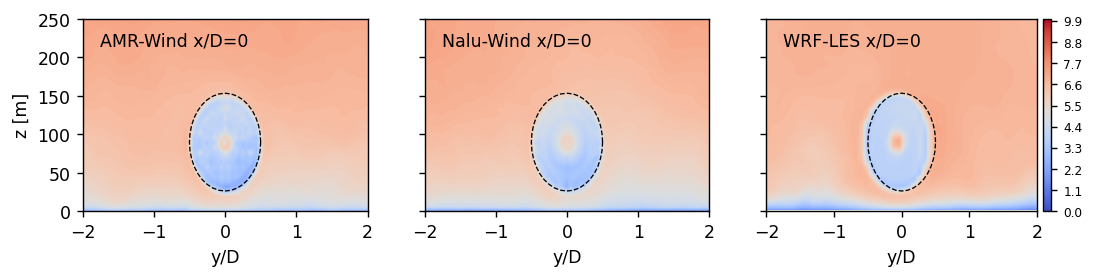

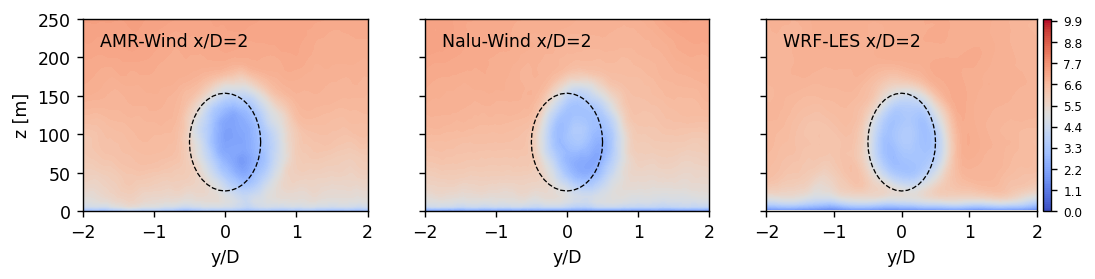

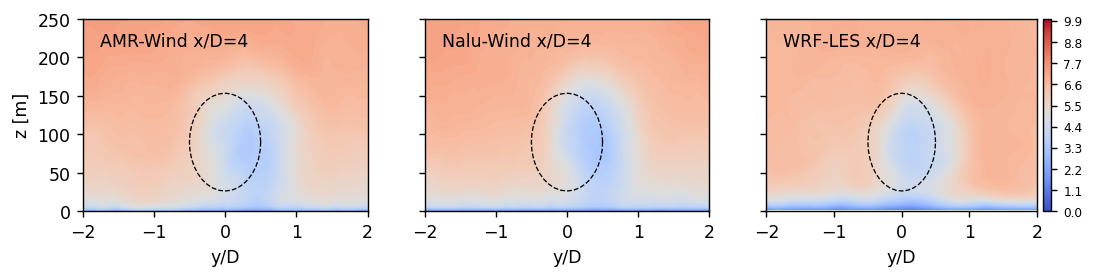

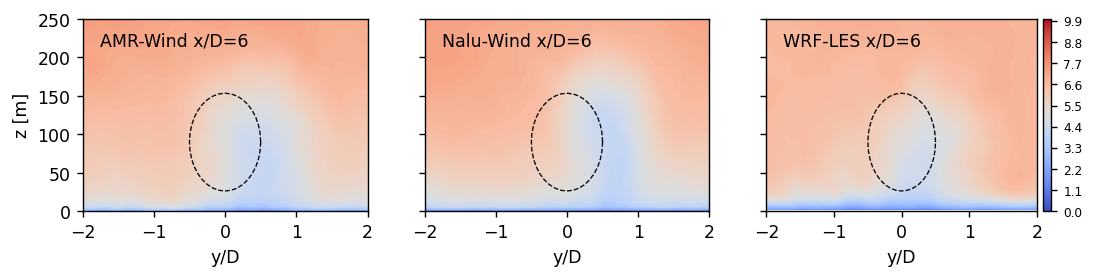

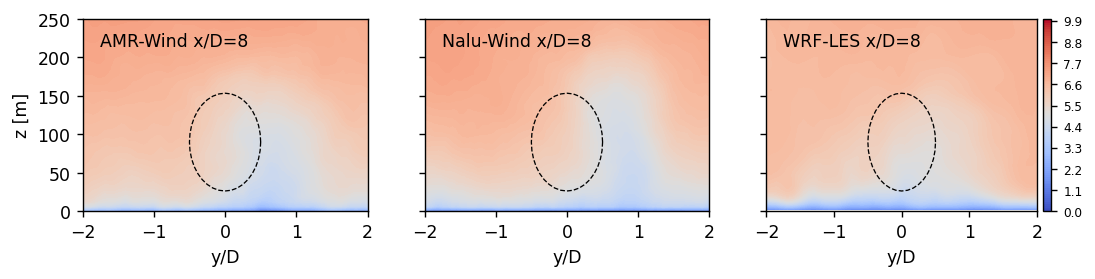

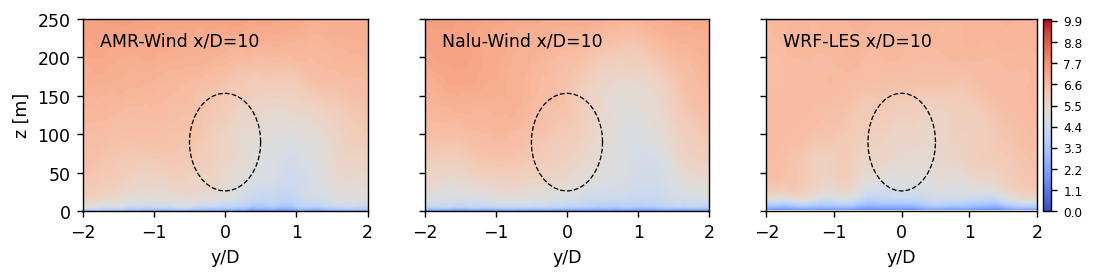

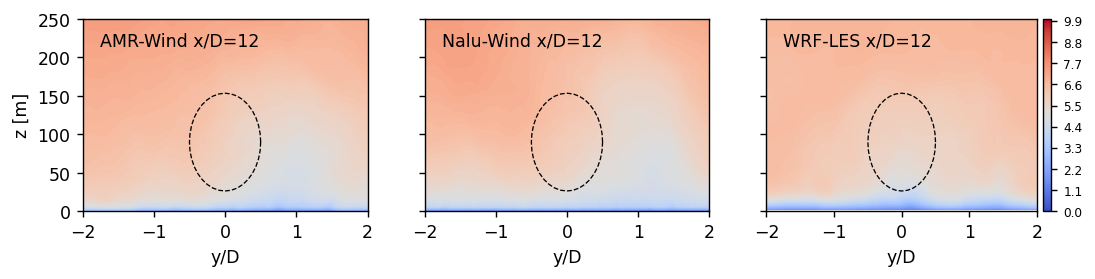

In [6]:
clevels=np.linspace(0, 10,101)
xplanes = [0, 2, 4, 6, 8, 10, 12]
xtarget = 0
for xtarget in xplanes:
    fig, axs = plt.subplots(1, len(cases), figsize=(10,2), dpi=125, sharey=True)
    for icase, case in enumerate(cases):
        ax = axs[icase]
        label   = case['label']
        datadir = case['datadir']
        fname   = case['fname_avg']
        readfunc = case['readfunc']
        y0      = case['y0']
        yscale  = case['yscale']
        Y, Z, U, V, W = readfunc(datadir+'/'+fname, xtarget)
        Uh=np.sqrt(U**2 + V**2)
        c=ax.contourf((Y-y0)/yscale, Z, Uh, levels=clevels, cmap='coolwarm')
        ax.set_xlim([-2,2])
        ax.set_ylim([0,250])
        ax.text(-1.75, 215, '%s x/D=%i'%(label,xtarget))
        ax.set_xlabel('y/D')
        plotRotorDisk(ax, 0, 0, zHH, rotorD, yscale=rotorD, zscale=1, numpoints=36, lstyle={'linestyle':'--', 'color':'k', 'lw':0.75})
        
        if icase == len(cases)-1:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="3%", pad=0.05)
            cbar=fig.colorbar(c, ax=ax, cax=cax)
            cbar.ax.tick_params(labelsize=7)
    axs[0].set_ylabel('z [m]')
    